In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
%matplotlib inline
import seaborn as sns
import seaborn as sb
from glob import iglob
import anndata
import matplotlib as mpl
import skmisc

    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable


fig_path= '../results/'

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


### Reading data

In [5]:
adata = sc.read('../data/rna1_counts_Tg_adata.h5ad')

### Note: T. gondii == Tg | H. sapiends == Hs

## Preview of Toxoplasma gondii UMIs

Looking at the human and Tg genes.

All the Tg genes have the preffix "TGGT1" 

In [6]:
adata.var.head()

,gene_ids,feature_types,mean,std
MIR1302-2HG,ENSG00000243485,Gene Expression,0.000065,0.005988
FAM138A,ENSG00000237613,Gene Expression,0.000003,0.000696
OR4F5,ENSG00000186092,Gene Expression,0.000000,1.000000
AL627309.1,ENSG00000238009,Gene Expression,0.007629,0.068289
AL627309.3,ENSG00000239945,Gene Expression,0.000000,1.000000


In [7]:
adata.var.tail()

,gene_ids,feature_types,mean,std
TGGT1_412230,TGGT1_412230,Gene Expression,0.0,1.0
TGGT1_412240,TGGT1_412240,Gene Expression,0.0,1.0
TGGT1_412250,TGGT1_412250,Gene Expression,0.0,1.0
TGGT1_412260,TGGT1_412260,Gene Expression,0.0,1.0
TGGT1_300641,TGGT1_300641,Gene Expression,0.0,1.0


In [8]:
## Selecting the names of the Tg genes only
tg= adata.var.index.str.contains('TGGT1')
print(sum(tg))

8637


In [51]:
adata

AnnData object with n_obs × n_vars = 125463 × 45238
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'mean', 'std'
    uns: 'log1p'
    layers: 'raw_counts'

#### Giving a flag to differentiate human and T. gondii genes in my data set. Preview of counts

In [11]:
## Giving a flag to differentiate human and Tg genes in my data set
##
adata.var['hs'] = adata.var.gene_ids.str.startswith('ENSG') ## all human genes
adata.var['tg'] = adata.var.gene_ids.str.startswith('TGGT1') ## all toxoplasma genes


## Calculating the metrics per cell in my data.
sc.pp.calculate_qc_metrics(adata, qc_vars=['hs'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['tg'], percent_top=None, log1p=False, inplace=True)

In [12]:
## Look at the hs and tg columns
adata.var.head()

,gene_ids,feature_types,mean,std,hs,tg,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,0.000065,0.005988,True,False,11,0.000162,99.983779,11.0
FAM138A,ENSG00000237613,Gene Expression,0.000003,0.000696,True,False,1,0.000015,99.998525,1.0
OR4F5,ENSG00000186092,Gene Expression,0.000000,1.000000,True,False,0,0.000000,100.000000,0.0
AL627309.1,ENSG00000238009,Gene Expression,0.007629,0.068289,True,False,1169,0.018123,98.276167,1229.0
AL627309.3,ENSG00000239945,Gene Expression,0.000000,1.000000,True,False,0,0.000000,100.000000,0.0


#### Checking the distribution of the number of genes from Hs and Tg

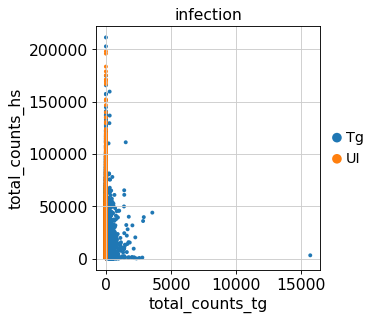

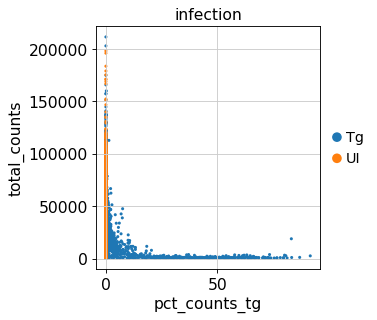

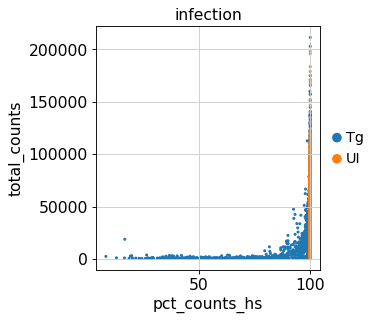

In [15]:
sc.pl.scatter(adata, x='total_counts_tg', y='total_counts_hs',  color="infection",size=50, save='_HsTgCounts.pdf')
sc.pl.scatter(adata, x='pct_counts_tg', y='total_counts', color="infection", size=30, save='_TotalvsTg.pdf')
sc.pl.scatter(adata, x='pct_counts_hs', y='total_counts', color="infection", size=30, save='_TotalvsHs.pdf')

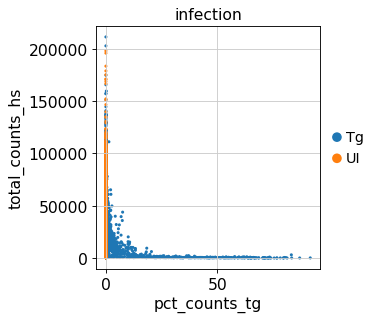

In [16]:
sc.pl.scatter(adata, x='pct_counts_tg', y='total_counts_hs', color="infection", size=30, save='_TgvsHs.pdf')

In [17]:
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 67814


In [18]:
adata.obs['sample'].values.describe()

,counts,freqs
categories,,
Pla_HDBR13007974,16274,0.239980
Pla_HDBR13007975,17962,0.264872
Pla_HDBR13798223,16936,0.249742
Pla_HDBR13798224,16642,0.245407


#### Checking if cells from uninfected samples have random (or not) counts from *T. gondii*

In [19]:
# percentage in a droplet has mostly human genes
#cells with more than 10% of Tg counts
sum(adata.obs.pct_counts_tg > 10)

319

In [31]:
## Uninfected:
# cells with more than 0% of Tg counts

nCells_infectedSamples=adata[adata.obs['infection'] == 'UI'].n_obs
print('Total cells from Uninfected explants: {:d}'.format(nCells_infectedSamples))

adata_temp= adata[adata.obs['infection'] == 'UI']
print('Uninfected cells with Tg counts >0%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 0)))
print('Uninfected cells with Tg counts >0.18%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 0.18)))
print('Uninfected cells with Tg counts >1%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 1)))

Total cells from Uninfected explants: 33210
Uninfected cells with Tg counts >0%: 91
Uninfected cells with Tg counts >0.18%: 0
Uninfected cells with Tg counts >1%: 0


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


#### Note:

There are 91 uninfected cells with >0% of Tg counts. However, none of the cells from uninfected samples have >0.18% of Tg counts. I will set this value as the value of Tg counts expected by chance, this will be my threshold to decide which cells are infected or not

#### Checking the same in cells from infected samples

In [20]:
## Infected explants
#cells with more than 0% of Tg counts

nCells_infectedSamples=adata[adata.obs['infection'] == 'Tg'].n_obs
print('Total cells from infected explants: {:d}'.format(nCells_infectedSamples))

adata_temp= adata[adata.obs['infection'] == 'Tg']
print('Infected cells with Tg counts >0%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 0)))
print('Infected cells with Tg counts >0.18%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 0.18)))
print('Infected cells with Tg counts >1%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 1)))

Total cells from infected explants: 34604
Infected cells with Tg counts >0%: 4745
Infected cells with Tg counts >0.18%: 1033
Infected cells with Tg counts >1%: 762


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


#### Q3: What is the maximum percentage of *T. gondii* reads observed by chance in uninfected samples?

In [35]:
print('The maximum % of Tg counts in cells from uninfected samples is: 0.18%')

The maximum % of Tg counts in cells from uninfected samples is: 0.18%


### Adding a flag to the metadata indicating if a cell is infected or not

The criteria is to have a % of Tg counts >0.18

In [45]:
#Selecting the cells with %Tg>0
temp=adata.obs.pct_counts_tg > 0.18

#Adding a new column with the flag in it. Boolean.
adata.obs['Tg_infected']= temp

In [47]:
adata.obs[adata.obs['Tg_infected']==True].head(5)

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,scrublet_score,scrublet_cluster_score,...,S_score,G2M_score,phase,n_genes_by_counts,total_counts,total_counts_hs,pct_counts_hs,total_counts_tg,pct_counts_tg,Tg_infected
Pla_HDBR13007975_AAACGAATCTCCGAGG,Pla_HDBR13007975,Tg_24h,Hrv171_Hrv172,24h,Tg,0.100336,2681.0,1,0.149024,0.068093,...,-0.057623,0.047559,G2M,1580,2681.0,2645.0,98.657211,36.0,1.342783,True
Pla_HDBR13007975_AAAGGATCAGTTAGGG,Pla_HDBR13007975,Tg_24h,Hrv171_Hrv172,24h,Tg,0.023619,11643.0,1,0.103614,0.087618,...,0.522926,-0.212491,S,3401,11643.0,9508.0,81.662804,2135.0,18.337198,True
Pla_HDBR13007975_AAAGTGAAGCACTAGG,Pla_HDBR13007975,Tg_24h,Hrv171_Hrv172,24h,Tg,0.068762,44981.0,1,0.476190,0.063521,...,-0.006966,-0.068845,G1,7121,44981.0,44839.0,99.684311,142.0,0.315689,True
Pla_HDBR13007975_AAATGGACAGATTAAG,Pla_HDBR13007975,Tg_24h,Hrv171_Hrv172,24h,Tg,0.031498,39113.0,1,0.063521,0.135447,...,-0.083740,-0.202879,G1,6407,39113.0,38911.0,99.483551,202.0,0.516452,True
Pla_HDBR13007975_AACAGGGCAGCTGAGA,Pla_HDBR13007975,Tg_24h,Hrv171_Hrv172,24h,Tg,0.020213,4700.0,1,0.099296,0.123535,...,-0.226769,-0.278997,G1,2051,4700.0,4356.0,92.680855,344.0,7.319149,True


## Save raw counts

In [48]:
# adding the raw counts
adata.X=adata.layers['raw_counts'].copy()
#adata.raw = adata.copy
adata.write('../data/rna1_counts_Tg_adata.h5ad')

In [12]:
#adata= sc.read('../data/rna1_counts_Tg_adata.h5ad')

### Most expressed Tg genes

#### First subsetting the cells flagged as infected with T. gondii

In [60]:
tg_data = adata[adata.obs['Tg_infected'] == True, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [61]:
tg_data

View of AnnData object with n_obs × n_vars = 1033 × 45238
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_hs', 'pct_counts_hs', 'total_counts_tg', 'pct_counts_tg', 'Tg_infected'
    var: 'gene_ids', 'feature_types', 'mean', 'std', 'hs', 'tg', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'infection_colors'
    layers: 'raw_counts'

In [62]:
# Find gene names containing "TGGT1", T. gondii genes
tg_genes = adata.var_names.str.contains("TGGT1")

# 2. Subset the gene expression matrix to those genes
tg_data = adata[:, tg_genes]

#### Q4: What are the top 10 most expressed T. gondii genes across cells flagged as infected?

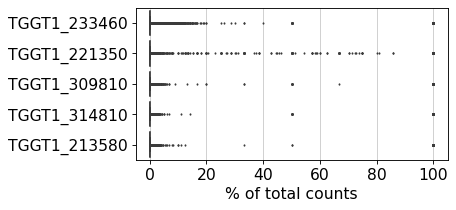

In [68]:
sc.pl.highest_expr_genes(tg_data, n_top=5)